In [20]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, fbeta_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import precision_recall_curve,auc
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost.sklearn")

In [2]:
def normalize2(row, mean_df, std_df, athlete_id):
    mu = mean_df.loc[athlete_id]
    su = std_df.loc[athlete_id]
    z = (row - mu)/su
    return z


In [3]:
def getMeanStd(data):
    mean = data[data['injury'] == 0].groupby('Athlete ID').mean()
    std = data[data['injury'] == 0].groupby('Athlete ID').std()
    std.replace(to_replace=0.0, value=0.01, inplace=True)
    return mean, std

In [14]:
def getBalancedSubset(X_train, samplesPerClass):
    healthySet   = pd.DataFrame()
    unhealthySet = pd.DataFrame()
    

    stats = pd.DataFrame(X_train[['Athlete ID','injury']].groupby(['Athlete ID','injury']).size().reset_index(name='counts'))
    stats = pd.DataFrame(stats[['Athlete ID']].groupby(['Athlete ID']).size().reset_index(name='counts'))
    stats.drop(stats[stats['counts'] < 2].index, inplace=True)
    athleteList = stats['Athlete ID'].unique()

    samplesPerAthlete = int(np.floor(samplesPerClass) / len(athleteList))

    for athlete in athleteList:
        if unhealthySet.empty:
            unhealthySet = X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 0)].sample(samplesPerAthlete, replace=True)
        else:
            unhealthySet = pd.concat([unhealthySet, X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 0)].sample(samplesPerAthlete,replace=True)], ignore_index=True)
        if healthySet.empty:
            healthySet = X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 1)].sample(samplesPerAthlete, replace=True)
        else:
            healthySet = pd.concat([healthySet, X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 1)].sample(samplesPerAthlete,replace=True)], ignore_index=True)


    balancedSet = pd.concat([healthySet, unhealthySet], ignore_index=True)
    return balancedSet

In [44]:
def prepare_balanced_data(df,test_athletes, sample_multiplier=1):

    X_test_original = df[df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy for normalization
    X_train_original = df[~df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy

    X_train_means, X_train_std = getMeanStd(X_train_original)
    X_test_means, X_test_std = getMeanStd(X_test_original)
    X_train_balanced = getBalancedSubset(X_train_original.copy(), (2048*sample_multiplier))
    
    # Set target variable for testing and training
    y_train = X_train_balanced['injury']
    y_test = X_test_original['injury']

    # Apply normalization to the balanced training data
    X_train_norm = X_train_balanced.apply(lambda x: normalize2(x, X_train_means, X_train_std, x['Athlete ID']), axis=1)
    X_train_norm = X_train_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')

    # Apply normalization to the test data using the testing statistics
    # Note this is a source of data leakage! but the alternative is not feasible
    X_test_norm = X_test_original.apply(lambda x: normalize2(x, X_test_means, X_test_std, x['Athlete ID']), axis=1)
    X_test_norm = X_test_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')


    return y_train, y_test, X_train_norm, X_test_norm

In [45]:
def prepare_balanced_nonorm(df,test_athletes, sample_multiplier=1):

    X_test_original = df[df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy for normalization
    X_train_original = df[~df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy

    X_train_balanced = getBalancedSubset(X_train_original.copy(), (2048 * sample_multiplier))
    
    # Set target variable for testing and training
    y_train = X_train_balanced['injury']
    y_test = X_test_original['injury']

    # Apply normalization to the balanced training data
    
    X_train= X_train_balanced.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')

    # Apply normalization to the test data using the testing statistics
    # Note this is a source of data leakage! but the alternative is not feasible
    X_test = X_test_original.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')


    return y_train, y_test, X_train, X_test

In [16]:
def train_model(X_train, y_train):
    xgbc = XGBClassifier()
    xgbc.fit(X_train, y_train)
    return xgbc
    

In [48]:
def train_with_params(X_train, y_train, X_val, y_val):  # Add validation data
    xgbc = XGBClassifier(
        objective='binary:logistic',  # Specify objective for binary classification
        eval_metric='logloss',        # Metric for early stopping
        use_label_encoder=False,      # Suppress a warning
        reg_alpha=0.3,              # L1 regularization
        reg_lambda=0.3,             # L2 regularization
        max_depth=3,                  # Limit tree depth
        subsample=0.6,                # Subsample ratio of the training instance.
        colsample_bytree=0.8          # Subsample ratio of columns when constructing each tree.
    )

    eval_set = [(X_val, y_val)]  # Validation data for early stopping
    xgbc.fit(X_train, y_train,
             early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
             eval_set=eval_set,
             verbose=False) 
    return xgbc

In [ ]:
def training_eval(model, y_true, X, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2)  # Emphasize recall

    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall(most important): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F-beta Score (beta=2): {fbeta:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot precision-recall curve
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, model.predict_proba(X)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()


In [25]:
dfday = pd.read_csv('../data/raw/day_approach.csv')
dfday.drop(list(dfday.filter(regex = 'perceived|sprinting|strength')), axis = 1, inplace = True)
athletes = sorted(list(dfday['Athlete ID'].unique()))
test_athletes = athletes[len(athletes) - 10:]



Accuracy: 0.8285
Precision: 0.0299
Recall: 0.3000
F1 Score: 0.0543
F-beta Score (beta=2): 0.1068


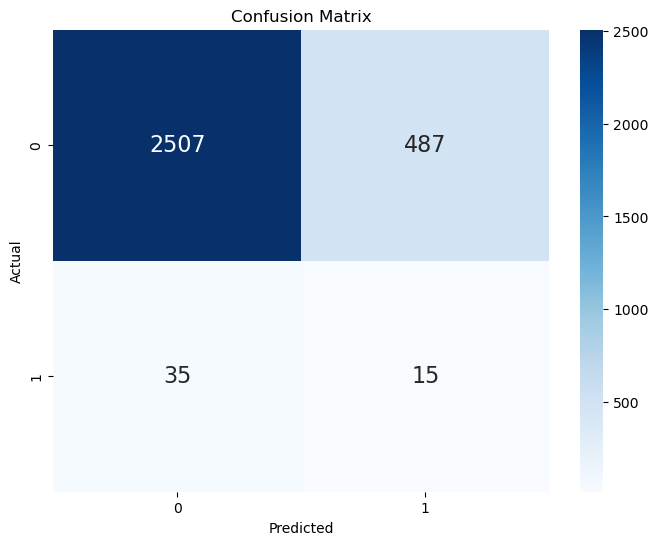

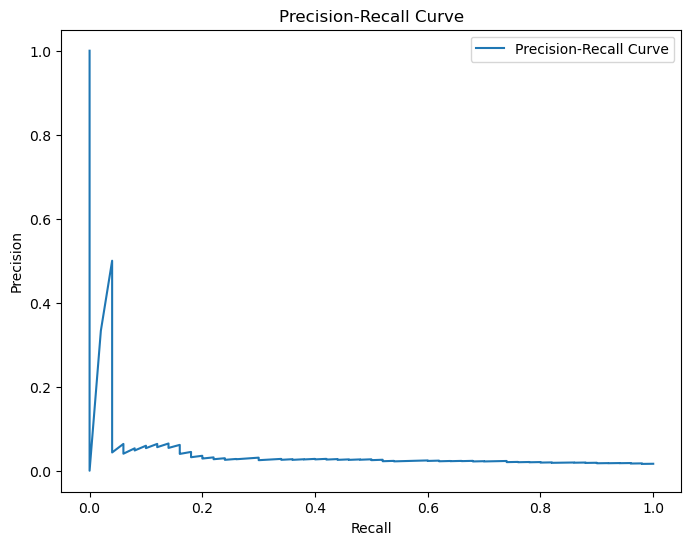

Accuracy: 0.9899
Precision: 1.0000
Recall: 0.9798
F1 Score: 0.9898
F-beta Score (beta=2): 0.9838


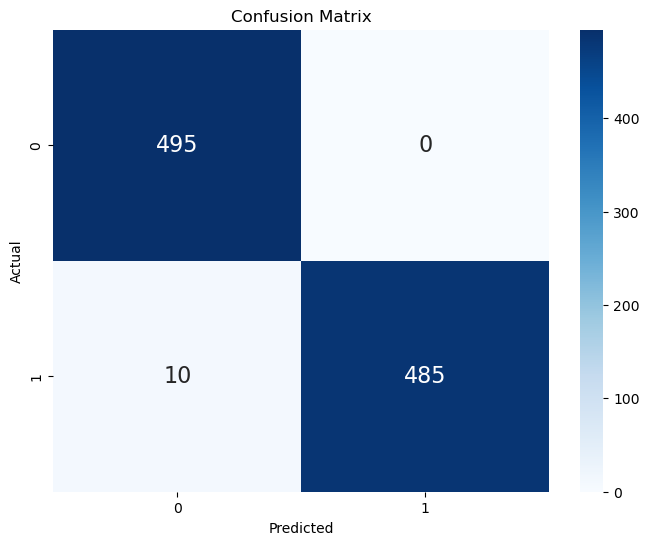

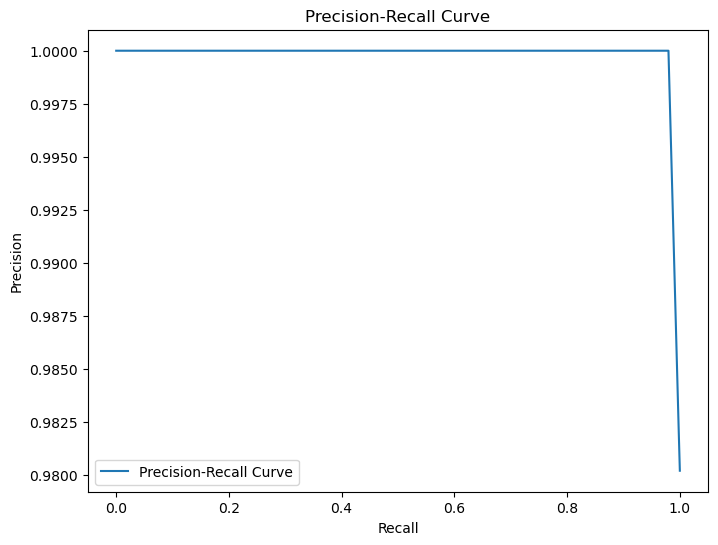

In [33]:
y_train, y_test, X_train, X_test = prepare_balanced_data(dfday, test_athletes)
model = train_model(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train) #predict training data

training_eval(model, y_test, X_test, y_pred_test) #evaluate test data
training_eval(model, y_train, X_train, y_pred_train) #evaluate training data


Accuracy: 0.9744
Precision: 0.0625
Recall: 0.0400
F1 Score: 0.0488
F-beta Score (beta=2): 0.0431


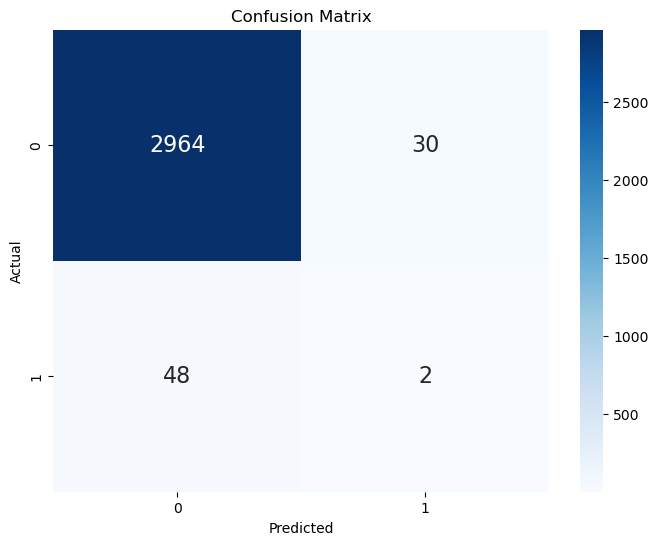

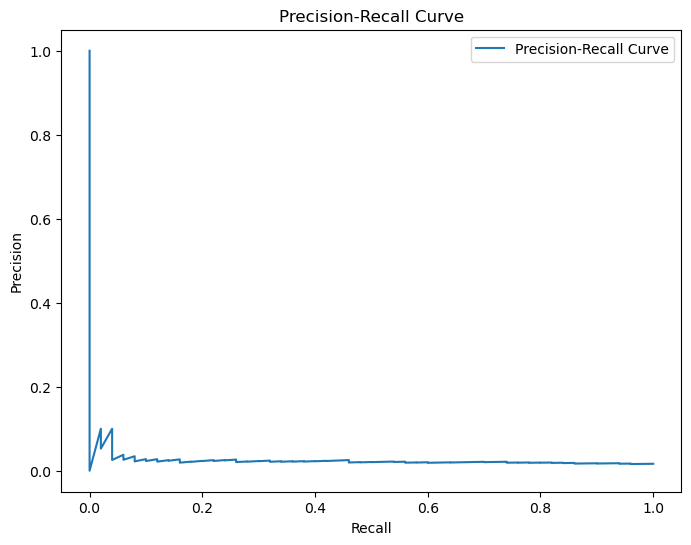

Accuracy: 0.9896
Precision: 0.9831
Recall: 0.9962
F1 Score: 0.9896
F-beta Score (beta=2): 0.9936


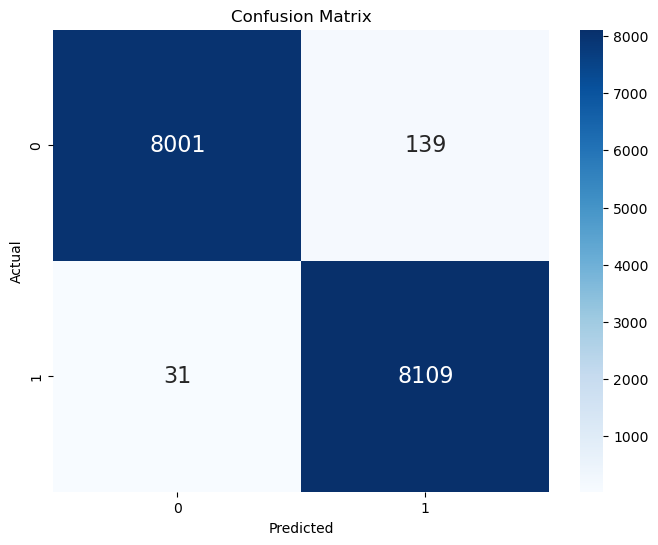

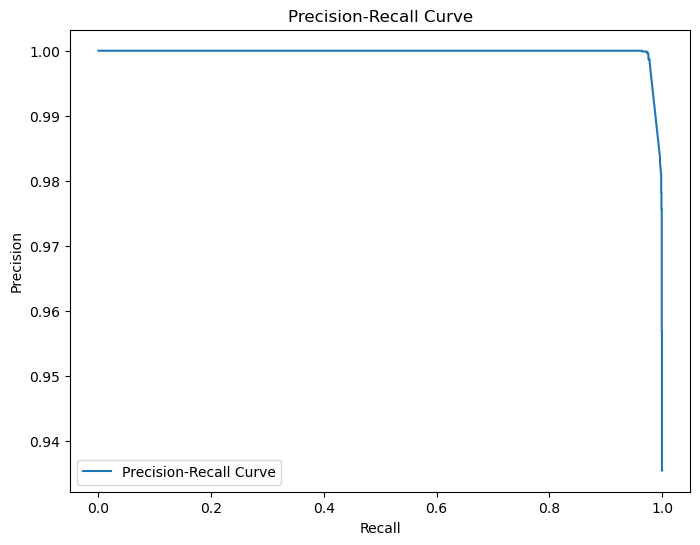

In [ ]:
# spc *4
y_train, y_test, X_train, X_test = prepare_balanced_data(dfday, test_athletes)
model = train_model(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train) #predict training data

training_eval(model, y_test, X_test, y_pred_test) #evaluate test data
training_eval(model, y_train, X_train, y_pred_train) #evaluate training data


Accuracy: 0.8978
Precision: 0.0453
Recall: 0.2600
F1 Score: 0.0772
F-beta Score (beta=2): 0.1335


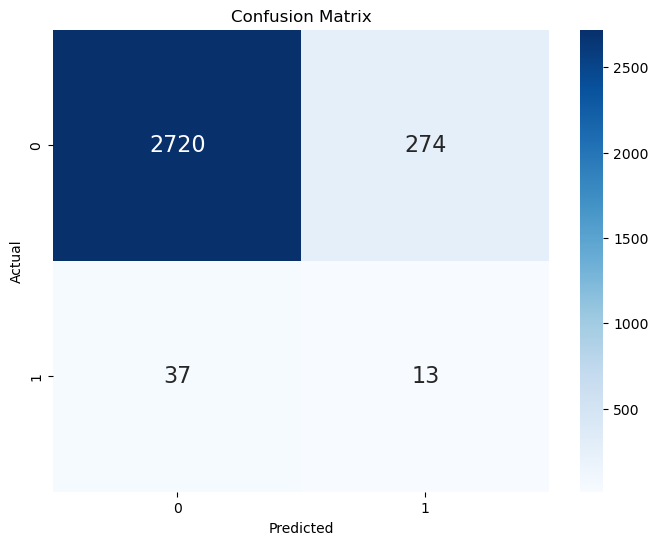

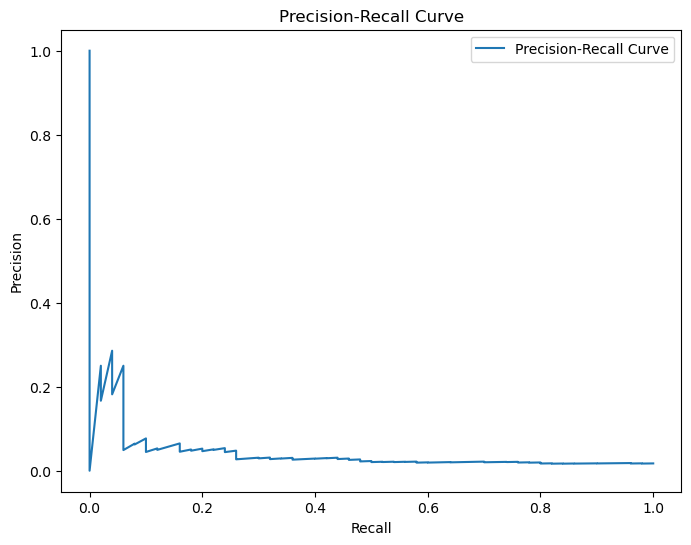

Accuracy: 0.9924
Precision: 0.9851
Recall: 1.0000
F1 Score: 0.9925
F-beta Score (beta=2): 0.9970


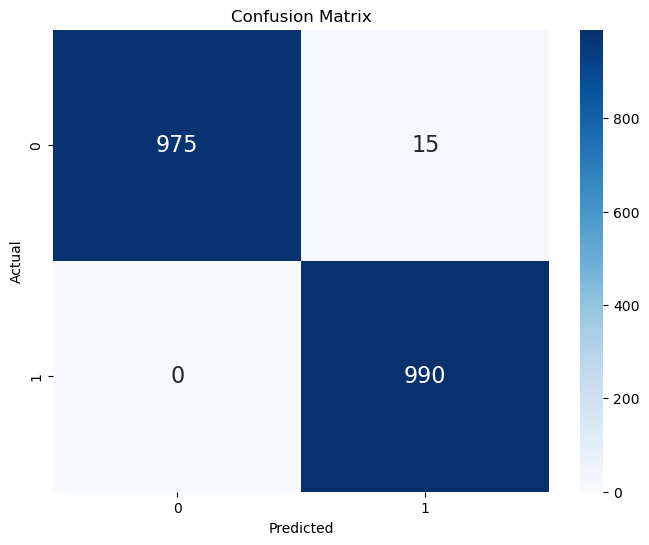

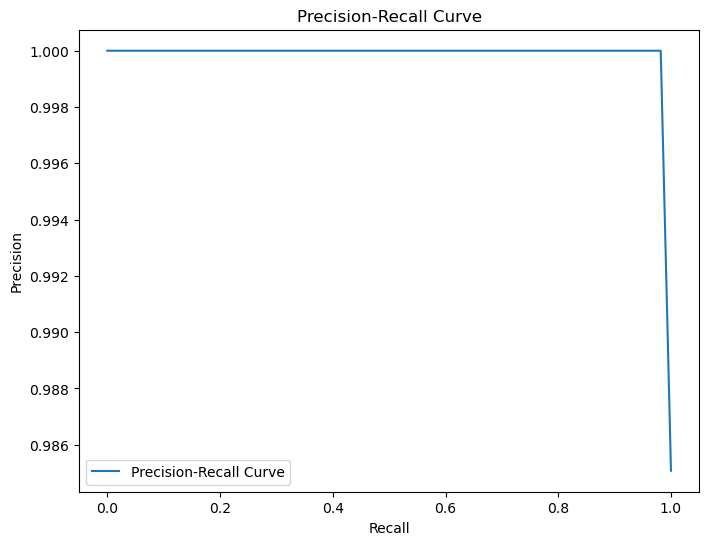

In [30]:
# spc * 0.5
y_train, y_test, X_train, X_test = prepare_balanced_data(dfday, test_athletes)
model = train_model(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train) #predict training data

training_eval(model, y_test, X_test, y_pred_test) #evaluate test data
training_eval(model, y_train, X_train, y_pred_train) #evaluate training data


Accuracy: 0.8239
Precision: 0.0272
Recall: 0.2800
F1 Score: 0.0496
F-beta Score (beta=2): 0.0980


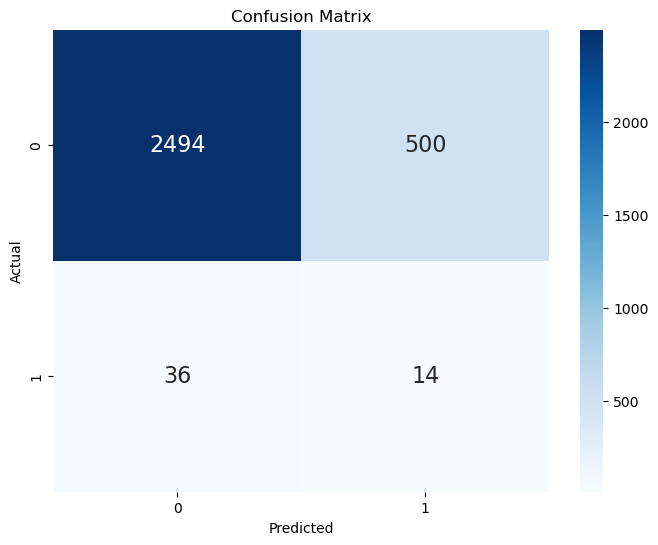

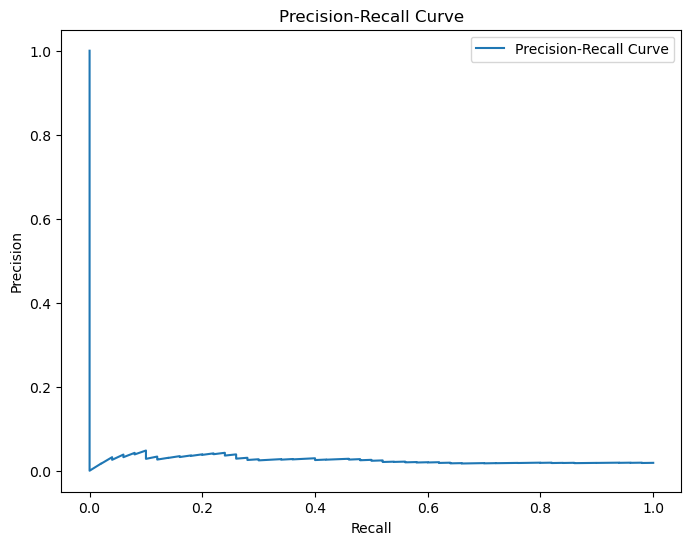

Accuracy: 0.9919
Precision: 0.9841
Recall: 1.0000
F1 Score: 0.9920
F-beta Score (beta=2): 0.9968


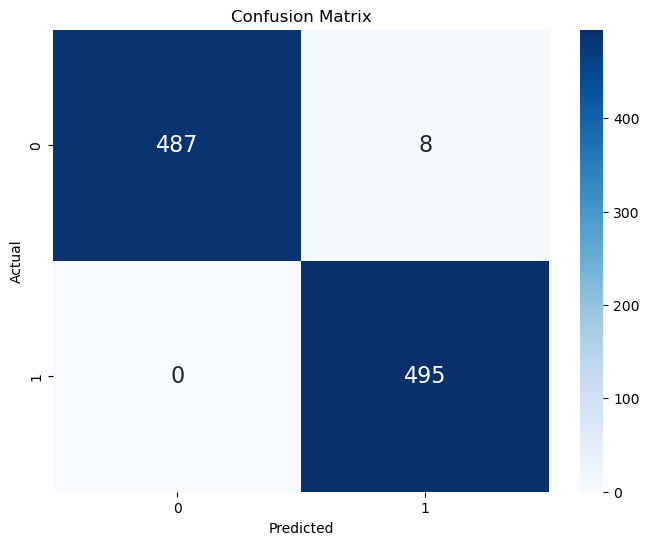

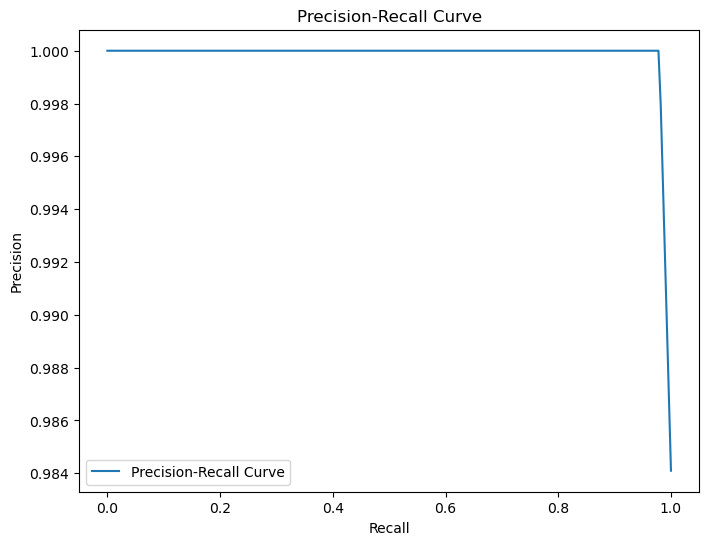

In [32]:
# spc * 0.25
y_train, y_test, X_train, X_test = prepare_balanced_data(dfday, test_athletes)
model = train_model(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train) #predict training data

training_eval(model, y_test, X_test, y_pred_test) #evaluate test data
training_eval(model, y_train, X_train, y_pred_train) #evaluate training data


Accuracy: 0.8778
Precision: 0.0320
Recall: 0.2200
F1 Score: 0.0558
F-beta Score (beta=2): 0.1011


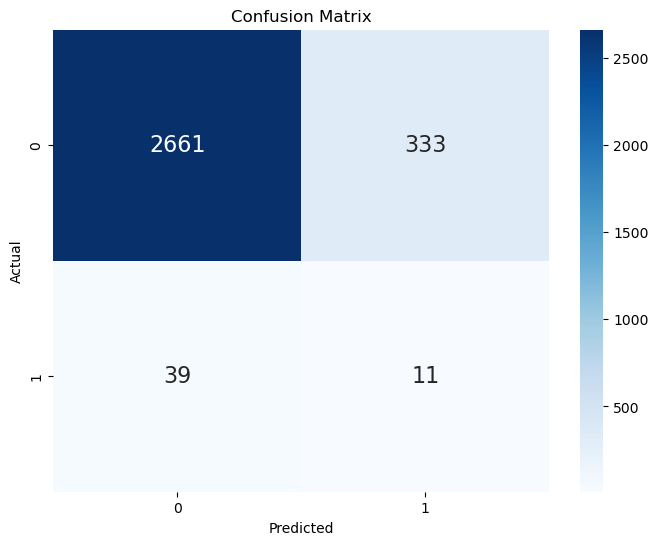

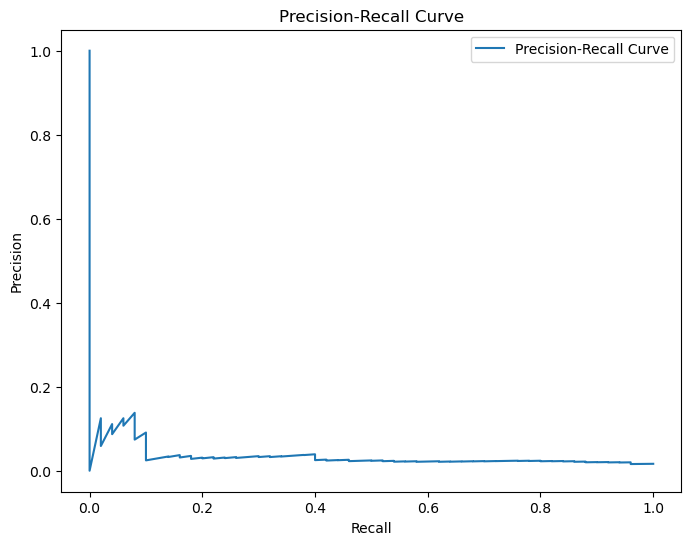

Accuracy: 0.9429
Precision: 0.9364
Recall: 0.9492
F1 Score: 0.9427
F-beta Score (beta=2): 0.9466


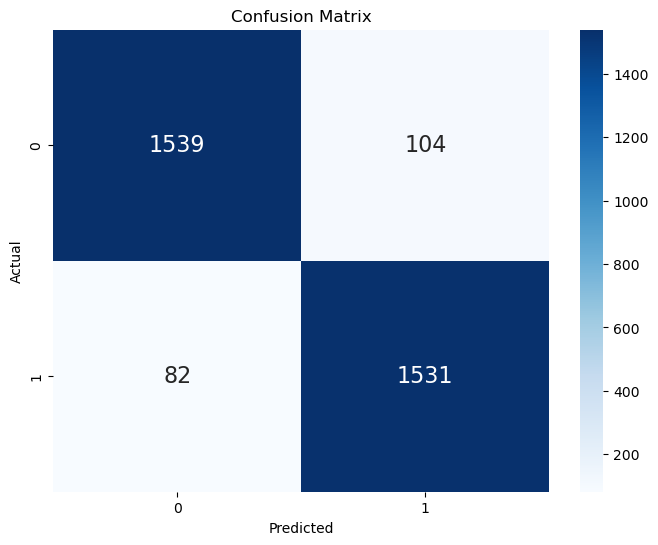

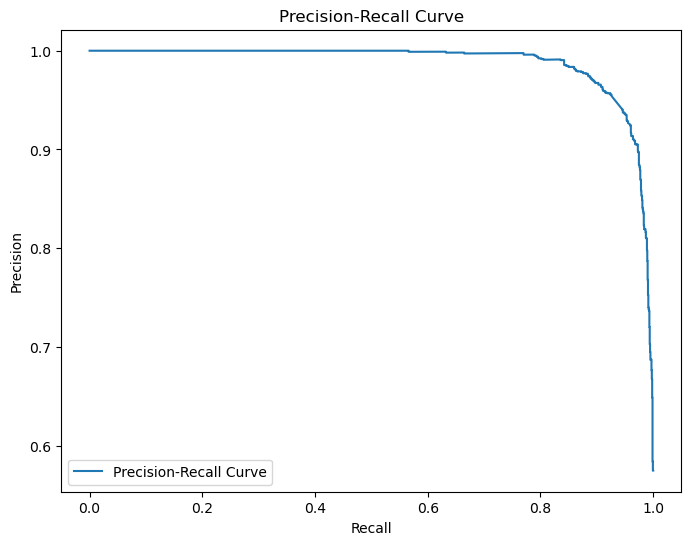

In [39]:
y_train, y_test, X_train, X_test = prepare_balanced_data(dfday, test_athletes)
from sklearn.model_selection import train_test_split 
X_train,X_val, y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 
# Split the training data into training and validation sets
model = train_with_params(X_train, y_train,X_val, y_val) # Train the model with validation data

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train) #predict training data

training_eval(model, y_test, X_test, y_pred_test) #evaluate test data
training_eval(model, y_train, X_train, y_pred_train) #evaluate training data


Accuracy: 0.6156
Precision: 0.0222
Recall: 0.5200
F1 Score: 0.0426
F-beta Score (beta=2): 0.0948


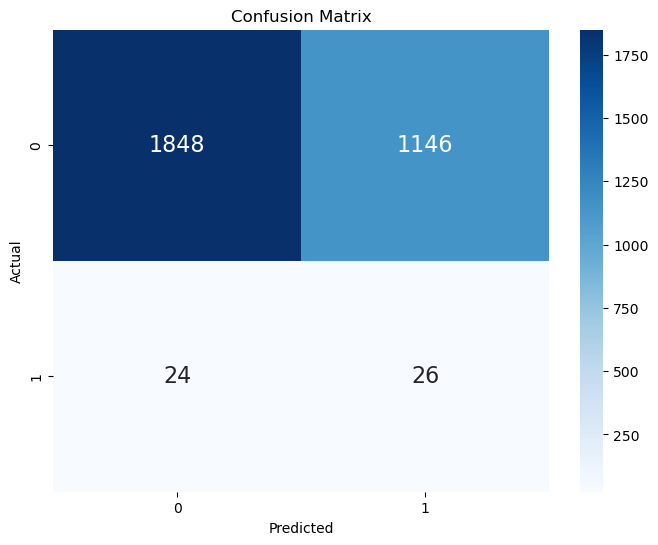

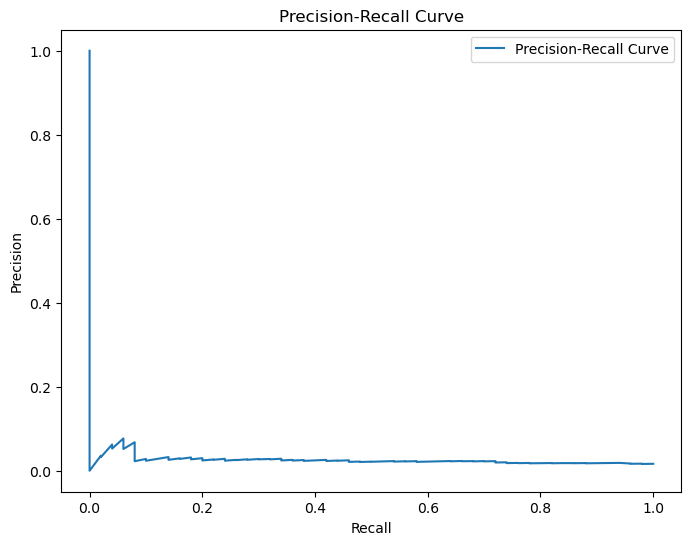

Accuracy: 0.7588
Precision: 0.7684
Recall: 0.7392
F1 Score: 0.7535
F-beta Score (beta=2): 0.7449


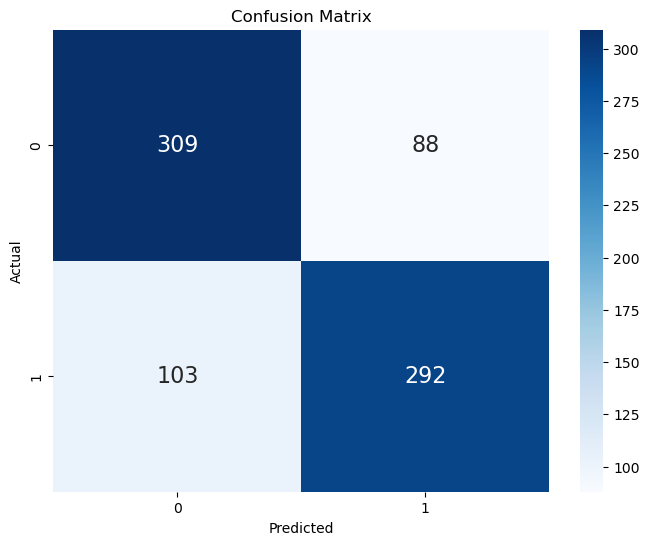

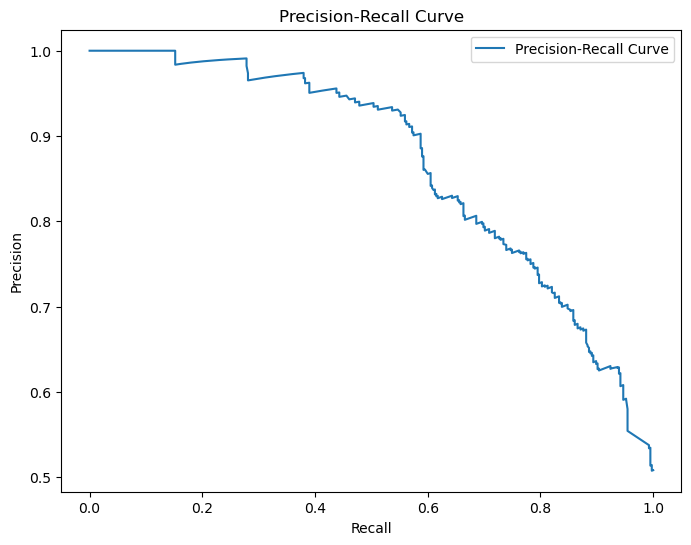

In [49]:
y_train, y_test, X_train, X_test = prepare_balanced_nonorm(dfday, test_athletes, sample_multiplier=0.25)
from sklearn.model_selection import train_test_split 
X_train,X_val, y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 
# Split the training data into training and validation sets
model = train_with_params(X_train, y_train,X_val, y_val) # Train the model with validation data

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train) #predict training data

training_eval(model, y_test, X_test, y_pred_test) #evaluate test data
training_eval(model, y_train, X_train, y_pred_train) #evaluate training data